在鐵達尼資料集中，今天我們專注觀察變數之間的相關性，以 Titanic_train.csv 中，首先將有遺失值的數值刪除，並回答下列問題。

In [1]:
import pandas as pd
import pingouin as pg
import researchpy
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv("titanic/Titanic_train.csv")
df1 = df.loc[:,["Age", "Survived", "Sex", "Fare"]]
print(df1.head())
print(df1.info())

    Age  Survived     Sex     Fare
0  22.0         0    male   7.2500
1  38.0         1  female  71.2833
2  26.0         1  female   7.9250
3  35.0         1  female  53.1000
4  35.0         0    male   8.0500
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
Age         714 non-null float64
Survived    891 non-null int64
Sex         891 non-null object
Fare        891 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 27.9+ KB
None


In [3]:
# 將 survived 轉成離散型變數
df1["Survived"] = df1["Survived"].astype("object")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
Age         714 non-null float64
Survived    891 non-null object
Sex         891 non-null object
Fare        891 non-null float64
dtypes: float64(2), object(2)
memory usage: 27.9+ KB


In [4]:
#Q1 透過數值法計算Age和Survived是否有相關性？
# Age: 連續型; Survived: 離散型。決定用 Eta Squared

df2 = df1[["Age", "Survived"]].dropna() #刪除缺失值

aov = pg.anova(dv='Age', between='Survived', 
               data=df2, detailed=True)
print(aov)

etaSq = aov.SS[0] / (aov.SS[0] + aov.SS[1])
print(etaSq)

     Source             SS   DF          MS         F     p-unc       np2
0  Survived     897.187582    1  897.187582  4.271195  0.039125  0.005963
1    Within  149559.448362  712  210.055405       NaN       NaN       NaN
0.0059630974469252


In [5]:
def judgement_etaSq(etaSq):
    if etaSq < .01:
        qual = "Negligible"
    elif etaSq < .06:
        qual = "Small"
    elif etaSq < .14:
        qual = "Medium"
    else:
        qual = "Large"
    return(qual)
print(judgement_etaSq(etaSq))

Negligible


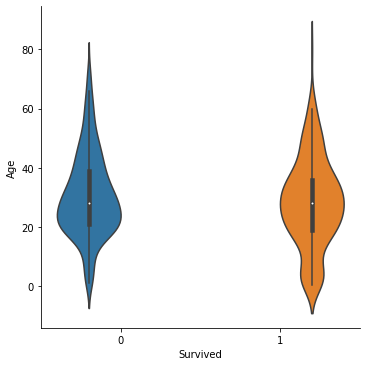

In [6]:
g = sns.catplot(x="Survived", y="Age", hue="Survived",
               data=df2, kind="violin")
#從 etaSq 和小提琴圖可以知道 survived 和 age 沒有相關性，
#我們需要思考是否要將這個放入模型，或是做特徵轉換

In [7]:
#Q2 透過數值法計算Sex和Survived是否有相關性？
# 離散對離散，決定使用 Cramér's V
contTable = pd.crosstab(df1["Sex"], df1["Survived"])
print(contTable)

#計算自由度
df_cont = min(contTable.shape[0], contTable.shape[1]) - 1
print("自由度 {}".format(df_cont))

#卡方檢定
crosstab, res = researchpy.crosstab(df1["Survived"], 
                                    df1["Sex"], test="chi-square")
print(res)
print("Cramer's value is", res.loc[2, "results"])

Survived    0    1
Sex               
female     81  233
male      468  109
自由度 1
                Chi-square test   results
0  Pearson Chi-square ( 1.0) =   263.0506
1                    p-value =     0.0000
2               Cramer's phi =     0.5434
Cramer's value is 0.5434


In [8]:
# 寫一個副程式判斷相關性的強度
def judgment_CramerV(df,V):
    if df == 1:
        if V < 0.10:
            qual = 'negligible'
        elif V < 0.30:
            qual = 'small'
        elif V < 0.50:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 2:
        if V < 0.07:
            qual = 'negligible'
        elif V < 0.21:
            qual = 'small'
        elif V < 0.35:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 3:
        if V < 0.06:
            qual = 'negligible'
        elif V < 0.17:
            qual = 'small'
        elif V < 0.29:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 4:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.15:
            qual = 'small'
        elif V < 0.25:
            qual = 'medium'
        else:
            qual = 'large'
    else:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.13:
            qual = 'small'
        elif V < 0.22:
            qual = 'medium'
        else:
            qual = 'large'
    return(qual)

judgment_CramerV(df_cont,res.loc[2,'results'])

'large'

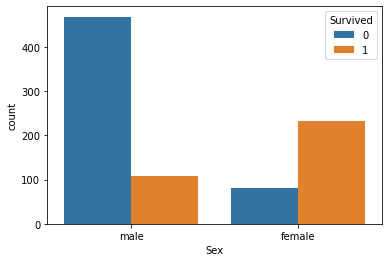

In [9]:
g = sns.countplot(x="Sex", hue="Survived", data=df1)
# 從 CramerV 和 圖形的判斷可以知道性別和存活有高度相關系，
# 所以要預測存活率會需要性別

In [10]:
#Q3 透過數值法計算Age和Fare是否有相關性？
# 連續對連續
df3 = df1[["Age", "Fare"]].dropna()
df3.head()

# 用 pearson correlation, 只要第一個回傳結果
corr, _ = stats.pearsonr(df3["Age"], df3["Fare"])
print(corr)

0.0960666917690389


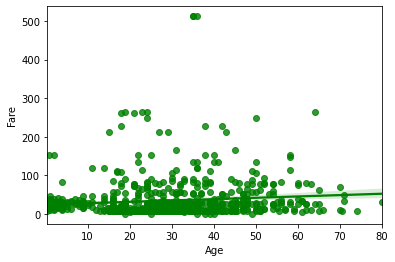

In [11]:
g = sns.regplot(x="Age", y="Fare", color="g", data=df3)
# 年紀和票價並沒有被觀察到線性關係，Pearson 相關係數也很小 0.09